In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import torch
from torch.autograd.functional import jacobian
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.linalg

## Step 1: Define the system dynamics

In [69]:
# Start with a simple linear system
# A single-integrator with damping
alpha = 0.1;
A = torch.tensor([[0, 1], [0, -alpha]]);
B = torch.tensor([[0], [1.0]])

def f(x, u):
    return torch.matmul(A, x) + torch.matmul(B, u)

n_dims = 2
n_controls = 1

## Step 2: Define the contraction metric and linear controller architecture

In [147]:
class ControllerNet(nn.Module):
    """A class to represent a linear controller for a dynamical system"""

    def __init__(self, n_dims, n_controls, A, B):
        super(ControllerNet, self).__init__()

        self.feedback_layer = nn.Linear(n_dims, n_controls, bias=False)
        
        self.n_dims = n_dims
        self.n_controls = n_controls

        # Initialize the controller using the LQR weights
        Q = np.eye(n_dims)
        R = np.eye(n_controls)
        X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
        K = np.matrix(scipy.linalg.inv(R)*(B.T*X))
        K = -torch.tensor(K)
        self.feedback_layer.weight = torch.nn.Parameter(K.float())
        
    def forward(self, x):
        """Compute the control input for state x - bs x n_dims x 1
        
        returns bs x n_controls x 1
        """
        return self.feedback_layer(x.squeeze()).reshape(-1, self.n_controls, 1)
    
    def K(self, x):
        """Compute the jacobian of the control for state x"""
        batch_size = x.shape[0]
        K = torch.zeros(batch_size, self.n_controls, self.n_dims)
        for batch_idx in range(batch_size):
            K[batch_idx, :, :] = jacobian(self.forward, x[batch_idx], create_graph=True).reshape(self.n_controls, self.n_dims)
        
        return K


class ContractionNet(nn.Module):
    """A class to represent a contraction metric for a dynamical system"""

    def __init__(self, n_dims):
        super(ContractionNet, self).__init__()
        
        self.n_dims = n_dims
        
        # For simplicity, let's just learn this as a constant function for now, then we
        # can make it more complicated. We'll also use the trick of learning M = Theta.T @ Theta
        self._Theta = nn.Parameter(torch.eye(n_dims))
        
    def M(self, x):
        """Get the metric matrix at state x"""
        Theta = self._Theta.unsqueeze(0).repeat(x.shape[0], 1, 1)
        Theta_T = Theta.transpose(1, 2)
        M_matrix = torch.bmm(Theta_T, Theta)

        return M_matrix
    
    def gradM(self, x):
        """Get the gradient of M wrt x"""
        batch_size = x.shape[0]
        gradM = torch.zeros(batch_size, self.n_dims, self.n_dims, self.n_dims)
        M_flat = lambda x: self.M(x).reshape(-1, 4)
        for batch_idx in range(batch_size):
            # This is gross
            J = jacobian(M_flat, x[batch_idx, :].unsqueeze(0), create_graph=True).squeeze().unsqueeze(0)
            J = J.permute(2, 0, 1).reshape(self.n_dims, self.n_dims, self.n_dims)
            gradM[batch_idx, :, :, :] = J
            
        
        return gradM
        
    def forward(self, x):
        """Compute the value of the metric for state x"""
        metric = F.bilinear(x, x, self.M(x))
        
        return metric

## Step 3: Learn a controller with a contraction metric

In [146]:
# Gather training and test points
N_train = 10000
N_test = 5000

x_max = torch.ones((n_dims,))
x_max[0] = 5.0
x_max[1] = 5.0
x_min = -x_max

# Sample training points
x_train = torch.rand((N_train, n_dims, 1))
for i in range(n_dims):
    x_train[:, i, 0] = x_train[:, i, 0] * (x_max[i] - x_min[i]) + x_min[i]

# And some test points
x_test = torch.rand((N_test, n_dims, 1))
for i in range(n_dims):
    x_test[:, i, 0] = x_test[:, i, 0] * (x_max[i] - x_min[i]) + x_min[i]

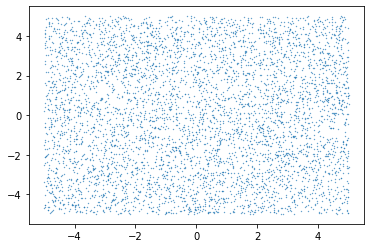

In [148]:
# Make sure we got it
plt.figure()
plt.scatter(x_test[:, 0], x_test[:, 1], 0.1)

In [149]:
def contraction_loss(x, u_net, M_net, lambda_M = 0.1):
    """Construct a loss based on the contraction metric property
    
    args:
        x - N_goal x n_dims tensor of points
        u_net - ControllerNet instance
        M_net - ContractionNet instance
        lambda_M - desired convergence rate
    """
    loss = 0.0
    batch_size = x.shape[0]
    
    # This is the simple loss (which Dawei describes as "hard") from eq(5)
    # in the neural contraction paper.
    
    # First get the time derivative of M
    M = M_net.M(x)
    with torch.enable_grad():
        gradM = M_net.gradM(x)
        closed_loop_jacobian = A + torch.matmul(B, u_net.K(x))

    u = u_net(x)
    xdot = f(x, u)
    Mdot = torch.zeros_like(M)
    for batch_idx in range(batch_size):
        for dim_idx in range(x.shape[1]):
            Mdot[batch_idx, :, :] += gradM[batch_idx, :, :, dim_idx] * xdot[batch_idx, dim_idx]
    
    MABK = torch.bmm(M, closed_loop_jacobian)
    
    C1 = Mdot + MABK.transpose(1, 2) + MABK + 2 * lambda_M * M

    # We want C1 to be positive definite
#     N_check = 100
#     x_check = torch.Tensor(N_check, x.shape[1]).uniform_(-1, 1)
#     xC1x = F.bilinear(x_check, x_check, C1)
#     loss += F.relu(xC1x).mean()
    for batch_idx in range(batch_size):
        eigenvalues, _ = torch.eig(C1[batch_idx], eigenvectors=True)
        loss += F.relu(eigenvalues.max()) / batch_size

    return loss

Now that we've defined all the needed networks and loss functions, we can start training!

In [151]:
# Define hyperparameters for the learning process
learning_rate = 1e-3
batch_size = 1
max_epochs = 10


# Define the network for learning the controller and certificates
u_net = ControllerNet(n_dims, n_controls, A, B)
M_net = ContractionNet(n_dims)
lambda_M = 0.05

# Train the networks
optimizer = optim.Adam(list(u_net.parameters())
                       + list(M_net.parameters()), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
best_loss = np.inf

epochs = range(max_epochs)
print("Starting training")
print(f"Theta:\n{M_net._Theta}")
print(f"K:\n{u_net.feedback_layer.weight}")
for epoch in epochs:
    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in tqdm(range(0, N_train, batch_size)):
        # Get samples from the state space
        indices = permutation[i:i+batch_size]
        x = x_train[indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Compute loss and backpropagate
        loss = 0.0
        loss += contraction_loss(x, u_net, M_net, lambda_M)
        loss.backward()
        
        loss_acumulated += loss.detach().item()

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Compute loss and backpropagate
        loss = 0.0
        CM_loss = contraction_loss(x_test, u_net, M_net, lambda_M)
        loss += CM_loss

        print(f"Test loss: {round(loss.item(), 8)}")
        test_losses.append(loss.detach().item())

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/cm_loss.pth.tar'
            torch.save({'M_net': M_net.state_dict(),
                        'u_net': u_net.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)
        if best_loss == 0:
            break
    
if best_loss == 0:
    print("Contraction metric found!")
    print(f"Theta:\n{M_net._Theta}")
    print(f"K:\n{u_net.feedback_layer.weight}")

Starting training
Theta:
Parameter containing:
tensor([[1., 0.],
        [0., 1.]], requires_grad=True)
K:
Parameter containing:
tensor([[-1.0000, -1.6349]], requires_grad=True)



Test loss: 0.0
Theta:
Parameter containing:
tensor([[0.9715, 0.0350],
        [0.0350, 0.9628]], requires_grad=True)
K:
Parameter containing:
tensor([[-1.0371, -1.5988]], requires_grad=True)
